# Surviving The Titanic and Random Forest Classifier

Done by Sahil Phule

##  Titanic dataset

In [107]:
# With the goal above, I will import just what I need. 
# The model to use (I already imported it above, but will do it again here so each example is self-contained)
from sklearn.ensemble import RandomForestRegressor

# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score

# An efficient data structure. 
import pandas as pd

#String operations
import re

%pylab inline


# Import the data
X = pd.read_csv("train.csv")
y = X.pop("Survived")

Populating the interactive namespace from numpy and matplotlib


In [108]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I know that there are categorical variables in the dataset, but I will skip them for the moment. I will impute age though, because it will be fast.

In [109]:
# Impute Age with mean
X["Age"].fillna(X.Age.mean(), inplace=True)

# Confirm the code is correct
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [110]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


I notice PassengerId looks like a worthless variable. I leave it in for two reasons. First, I don't want to go through the effort of dropping it (although that would be very easy). Second, I am interested in seeing if it is useful for prediction. It might be useful if the PassengerId was assigned in some non-random way. For example, perhaps PassengerId was assigned based on when the ticket was purchased in which case there might be something predictive about people who purchased their tickets early or late.

In [111]:
# Let's build our first model. I always have oob_score=True. It is a good idea to increase n_estimators to a number higher than 
# the default. In this case the oob_predictions will be based on a forest of 33 trees. I set random_state=42 so that you all can
# replicate the model exactly.
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [112]:
# For regression, the oob_score_ attribute gives the R^2 based on the oob predictions. We want to use c-stat, but I mention this 
# for awareness. By the way, attributes in sklearn that have a trailing underscore are only available after the model has been fit.
model.oob_score_

0.1361695005913669

In [113]:
y_oob = model.oob_prediction_
print "c-stat: ", roc_auc_score(y, y_oob)

c-stat:  0.73995515504


We now have a benchmark. This isn't very good for this dataset; however, it provides us a benchmark for improvement. Before changing parameters for the Random Forest, let's whip this dataset into shape.

In [114]:
# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [115]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


## Some Feature Engineering..!!

### Getting the titles from name

The passenger names can be broken down into some meaningful terms.

The we can use the titles of the name for analysis and the the last names can be used to represent families

In [116]:
def get_titles(x):
    return re.sub("(.*, )|(\\..*)", "", x)


Titles = X.Name.apply(get_titles)

In [117]:
Titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

### Standarizing the titles

In [118]:
# Combining the exotic titles in a array..!!
exotic_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

#convert mlle, ms, and mme according to standard type or exotic
def convert_to_standard(x):
    if(x=="Mlle" or x== "Ms"):
        return "Miss"
    if(x== "Mme"):
        return "Mrs"
    if (x in exotic_titles):
        return "Exotic"
    return x



In [119]:
Titles = Titles.apply(convert_to_standard)

In [120]:
Titles.unique()


array(['Mr', 'Mrs', 'Miss', 'Master', 'Exotic'], dtype=object)

### Getting Last Names

In [121]:
Lastnames= X.Name.str.partition(",")[0]

In [122]:
Lastnames.unique()

array(['Braund', 'Cumings', 'Heikkinen', 'Futrelle', 'Allen', 'Moran',
       'McCarthy', 'Palsson', 'Johnson', 'Nasser', 'Sandstrom', 'Bonnell',
       'Saundercock', 'Andersson', 'Vestrom', 'Hewlett', 'Rice',
       'Williams', 'Vander Planke', 'Masselmani', 'Fynney', 'Beesley',
       'McGowan', 'Sloper', 'Asplund', 'Emir', 'Fortune', "O'Dwyer",
       'Todoroff', 'Uruchurtu', 'Spencer', 'Glynn', 'Wheadon', 'Meyer',
       'Holverson', 'Mamee', 'Cann', 'Nicola-Yarred', 'Ahlin', 'Turpin',
       'Kraeff', 'Laroche', 'Devaney', 'Rogers', 'Lennon', "O'Driscoll",
       'Samaan', 'Arnold-Franchi', 'Panula', 'Nosworthy', 'Harper',
       'Faunthorpe', 'Ostby', 'Woolner', 'Rugg', 'Novel', 'West',
       'Goodwin', 'Sirayanian', 'Icard', 'Harris', 'Skoog', 'Stewart',
       'Moubarek', 'Nye', 'Crease', 'Kink', 'Jenkin', 'Hood',
       'Chronopoulos', 'Bing', 'Moen', 'Staneff', 'Moutal', 'Caldwell',
       'Dowdell', 'Waelens', 'Sheerlinck', 'McDermott', 'Carrau', 'Ilett',
       'Backstrom

In [123]:
len(Lastnames.unique())

667

There are 667 unique last names. Based on that we can find out the ethnicity. But that is beyound the scope of this assignment..!!!!

### Generating Families

Now that the names have been separated, we can use them to create family variables

In [124]:
# creating family size including the person
family_size=X.SibSp+X.Parch+1

# giving names to family size based of the number of people present in family
def give_sizenames(x):
    if (x== 1):
        return "alone"
    if (x > 1 and x < 5):
        return "small"
    if (x > 4):
        return "huge"

In [125]:
family_size=family_size.apply(give_sizenames)

### Separating children

Children were given priority on during the resuce. So it would be good to have a separate column for children

In [126]:
#function for finding children 1= child 0= adult
def isChild(x):
    if(x < 18):
        return 1
    return 0

In [127]:
Children = X.Age.apply(isChild)

### Adding the Titles and family size to the dataset

In [128]:
X['Titles']= Titles
X['Family_Size']=family_size

In [129]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))

printall(X)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_Size
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Mr,small
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs,small
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,alone
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs,small
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Mr,alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,Exotic,alone
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Miss,alone
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,Miss,small
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Mr,alone


In [130]:
# Drop the variables I don't feel like dealing with for this tutorial
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [131]:
# Change the Cabin variable to be only the first letter or None
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"

X["Cabin"] = X.Cabin.apply(clean_cabin)

In [132]:
categorical_variables = ['Sex', 'Cabin', 'Embarked', 'Titles', 'Family_Size']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [133]:
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_Q,Embarked_S,Titles_Exotic,Titles_Master,Titles_Miss,Titles_Mr,Titles_Mrs,Family_Size_alone,Family_Size_huge,Family_Size_small
0,3,22.000000,1,0,7.2500,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,35.000000,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,35.000000,0,0,8.0500,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,3,29.699118,0,0,8.4583,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,1,54.000000,0,0,51.8625,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,3,2.000000,3,1,21.0750,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,3,27.000000,0,2,11.1333,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,2,14.000000,1,0,30.0708,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [134]:
#show all columns
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S,Titles_Exotic,Titles_Master,Titles_Miss,Titles_Mr,Titles_Mrs,Family_Size_alone,Family_Size_huge,Family_Size_small
0,3,22.000000,1,0,7.2500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,35.000000,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,35.000000,0,0,8.0500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
887,1,19.000000,0,0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
888,3,29.699118,1,2,23.4500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
889,1,26.000000,0,0,30.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [135]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print "C-stat: ", roc_auc_score(y, model.oob_prediction_)

C-stat:  0.867885789154


This is a pretty good model. Now, before we try some different parameters for the model, let's use the Random Forest to help us with some EDA.

### Variable importance measures

In [136]:
model.feature_importances_

array([  7.86295096e-02,   1.97370669e-01,   1.89954503e-02,
         1.45585485e-02,   2.07447351e-01,   4.33339863e-02,
         4.51045712e-02,   2.24306358e-03,   4.01200413e-03,
         6.18085318e-03,   5.12706853e-03,   8.50807759e-03,
         7.29932904e-04,   1.25076996e-03,   2.07326897e-02,
         1.52511814e-04,   8.31469255e-03,   0.00000000e+00,
         5.98419044e-03,   1.09361348e-02,   2.17602223e-02,
         5.77904597e-03,   3.90353844e-03,   2.32834084e-01,
         3.78039063e-03,   5.45091943e-03,   3.98006791e-02,
         7.07904431e-03])

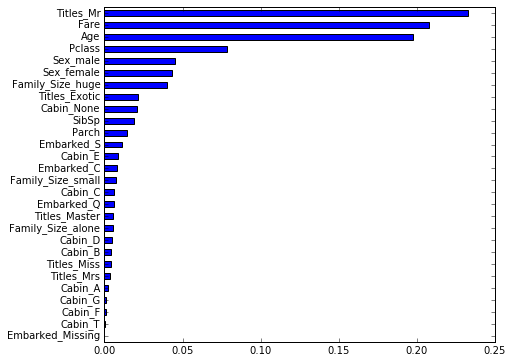

In [138]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(7,6));

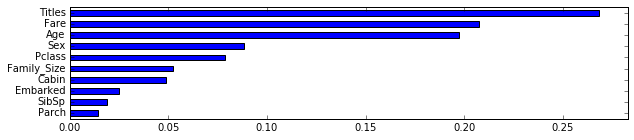

In [139]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort_values(inplace=True)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

## Parameter tests

Parameters to test

 * ###Parameters that will make your model better
  * <b>n_estimators</b>: The number of trees in the forest. Choose as high of a number as your computer can handle.
  * <b>max_features</b>: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
  * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers such as 1 through 10.
 * ###Parameters that will make it easier to train your model
  * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).

### n_jobs

In [140]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 2.48 s per loop


In [141]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 2.02 s per loop


### n_estimators

30 trees
C-stat:  0.859049947273

50 trees
C-stat:  0.862333429201

100 trees
C-stat:  0.867885789154

200 trees
C-stat:  0.868852459016

500 trees
C-stat:  0.868841807007

1000 trees
C-stat:  0.868378444594

2000 trees
C-stat:  0.867707367995



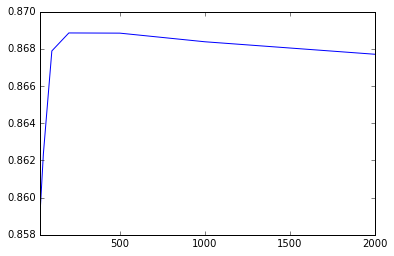

In [142]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print trees, "trees"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, n_estimator_options).plot();

### max_features

auto option
C-stat:  0.868378444594

None option
C-stat:  0.868378444594

sqrt option
C-stat:  0.864780728384

log2 option
C-stat:  0.863406619159

0.9 option
C-stat:  0.868884415045

0.2 option
C-stat:  0.864780728384



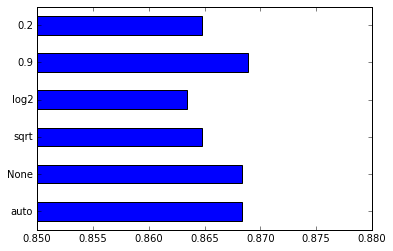

In [143]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print max_features, "option"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

### min_samples_leaf

1 min samples
C-stat:  0.868378444594

2 min samples
C-stat:  0.87341950809

3 min samples
C-stat:  0.875653767083

4 min samples
C-stat:  0.876761576071

5 min samples
C-stat:  0.877011898295

6 min samples
C-stat:  0.87699592028

7 min samples
C-stat:  0.877134396404

8 min samples
C-stat:  0.876207671577

9 min samples
C-stat:  0.87497736448

10 min samples
C-stat:  0.873805643435



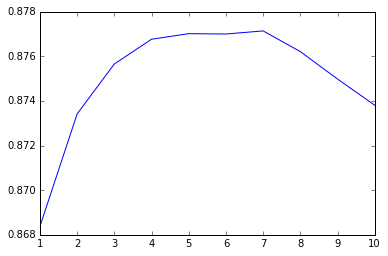

In [144]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print min_samples, "min samples"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

## Final model

In [145]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=7)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print "C-stat: ", roc

C-stat:  0.877134396404
